# 1 Нормальное распределение

Автоматизация процесса прогнозирования параметрической надёжности полупроводниковых приборов с использованием математической модели на основе нормального распределения.


In [1]:
# Подключение библиотек и настройка программного окружения
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as sps
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
sns.set_style("darkgrid")
%matplotlib inline

Определение глобальных переменных для автоматизированного расчёта

* `column_from`, `column_to` - условные столбцы файла данных, содержащие значения электрического параметра $y(t)$ при различных значениях наработки, в том числе при $t=0$; этот параметр может использоваться при хранении в одном файле информации о нескольких электрических параметрах ППП
* `bottom_limit`, `top_limit` - числовые пределы $a$ и $b$ норм электрического параметра полупроводникового прибора $y(t)$ (в соответствии с выражением (1) методики)
* `test_size` - объём обучающей выборки в % относительно количества всех полупроводниковых приборов, участвующих в испытаниях (по умолчанию, 50 %)
* `random_state` - псевдослучайный вариант разделения общей выборки на обучающую и контрольную (при изменении этого параметра содержимое выборок будет меняться)
* `shape` - предустаносленный коэффициент формы для модели Вейбулла



In [2]:
from numpy.ma.core import shape
# Определение глобальных переменных
column_from = 8 # 1 # 8
column_to = 15 # 8 # 15
bottom_limit = 0.665 # 1.8 # 0.665
top_limit = .71 # 1.84 # .71
test_size = 0.5
random_state = 40
shape = 3 # 5.5

Загрузка данных из файла csv в формате, соответствующем п.11.5 проекта методики.
Вместо текстовой переменной необходимо прописать путь к файлу с данными.

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/Margoffka/processing-data/main/dataset.csv")
columns = data.columns[column_from : column_to]
time_labels = [int(i.split('_')[1]) for i in columns]
param_name = columns[0].split('_')[0]
train, test = train_test_split(data, test_size=test_size, random_state=random_state)
# Деление обучающей выборки на 3 группы
train_splits = np.split(train, [int(.33*len(train)), int(0.66*len(train))])

Отображение экспериментальных графиков зависимости изменения параметра от наработки (в целях контроля правильности чтения файла и отображения зависимостей)

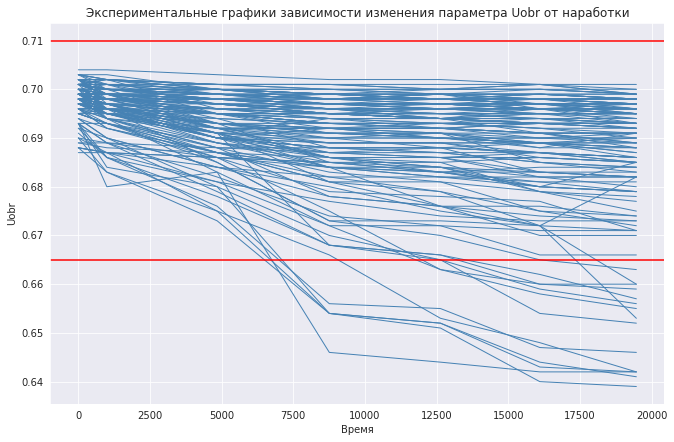

In [4]:
plt.figure(figsize=(11, 7))
plt.title('Экспериментальные графики зависимости изменения параметра ' + param_name + ' от наработки')
plt.xlabel('Время')
plt.ylabel(param_name)
for i in data[columns].iloc:
    data_fig = np.array(i)
    # plt.xlabel('time')
    plt.plot(time_labels, data_fig, color='steelblue', linewidth=1)
plt.axhline(y=bottom_limit, xmin=0, xmax=1, color='r', linewidth=1.5)
plt.axhline(y=top_limit, xmin=0, xmax=1, color='r', linewidth=1.5)

In [5]:
linear_regression = []
mean = []
std = []
for i in train_splits:
    train_mean0 = np.array(i[columns[0]]).mean()
    train_std0 = np.array(i[columns[0]]).std()
    for t, c in zip(time_labels, columns):
        linear_regression.append([t, train_mean0, train_std0])
        mean.append(np.array(i[c]).mean())
        std.append(np.array(i[c]).std())
linear_regression = np.array(linear_regression)

Анализ изменения среднего значения и скреднеквадратического отклонения параметра.

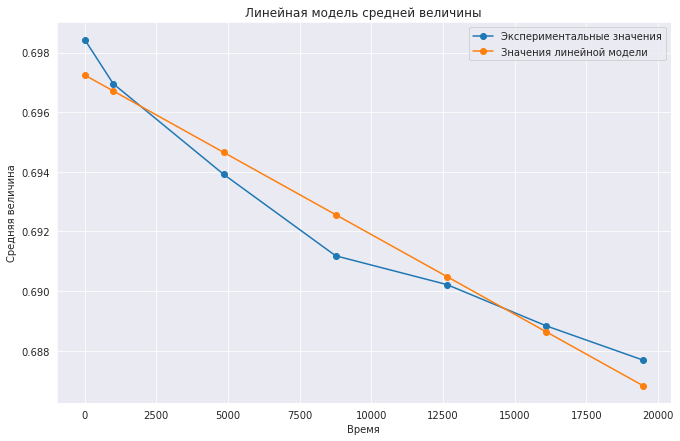

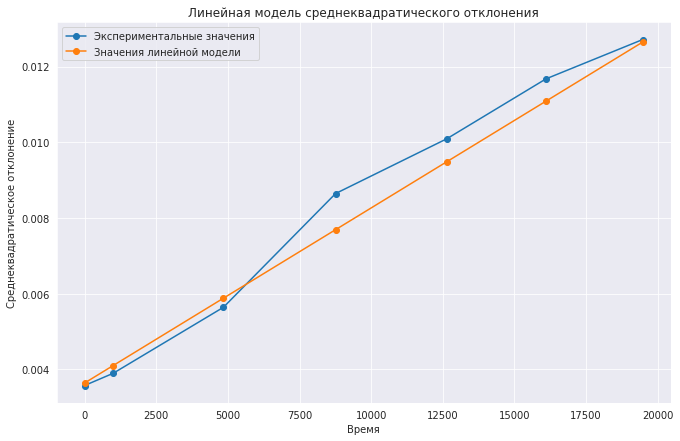

In [6]:
# Получение линейной модели средней величины параметра
model_mean = LinearRegression()
model_mean.fit(linear_regression, mean)

# Получение линейной модели среднеквадратического отклонения параметра
model_std = LinearRegression()
model_std.fit(linear_regression, std)

train_mean0 = np.array(train[columns[0]]).mean()
train_std0 = np.array(train[columns[0]]).std()
linear_regression_train = np.array([[i, train_mean0, train_std0] for i in time_labels])

plt.figure(figsize=(11, 7))
plt.title('Линейная модель средней величины')
plt.xlabel('Время')
plt.ylabel('Средняя величина')
plt.plot(time_labels, [np.array(train[i]).mean() for i in columns], label="Экспериментальные значения", marker="o")
plt.plot(time_labels, model_mean.predict(linear_regression_train), label="Значения линейной модели", marker="o")
plt.legend()

plt.figure(figsize=(11, 7))
plt.title('Линейная модель среднеквадратического отклонения')
plt.xlabel('Время')
plt.ylabel('Среднеквадратическое отклонение')
plt.plot(time_labels, [np.array(train[i]).std() for i in columns], label="Экспериментальные значения", marker="o")
plt.plot(time_labels, model_std.predict(linear_regression_train), label="Значения линейной модели", marker="o")
plt.legend()

In [7]:
test_mean0 = np.array(test[columns[0]]).mean()
test_std0 = np.array(test[columns[0]]).std()
linear_regression_test = np.array([[i, test_mean0, test_std0] for i in time_labels])
mean_test = model_mean.predict(linear_regression_test)
std_test = model_std.predict(linear_regression_test)

Получение для каждой временной точки модели на основе нормального закона распределения. Здесь на графиках

* вертикальные линии *(красный цвет)* - числовые пределы $a$ и $b$ норм электрического параметра полупроводникового прибора $y(t)$ (в соответствии с выражением (1) методики)
* столбиковая диаграмма *(синий цвет)* - экспериментальное распределение параметра в указанную временную точку
* кривая нормального распределения *(оранжевый цвет)* - смоделированная условная плотность распределения $w(y)_{t=i}$ параметра в указанной временной точке

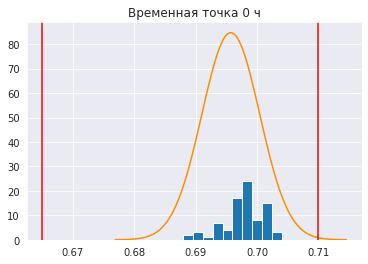

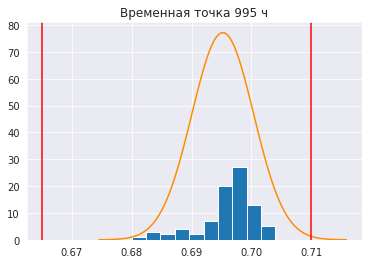

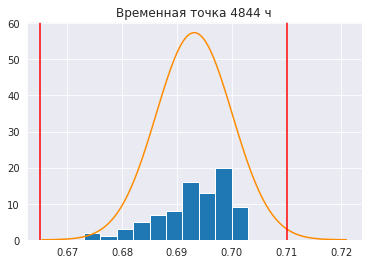

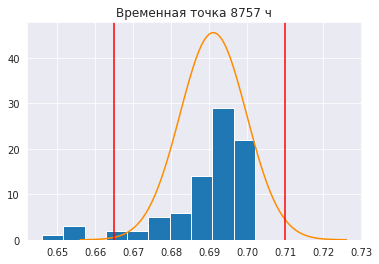

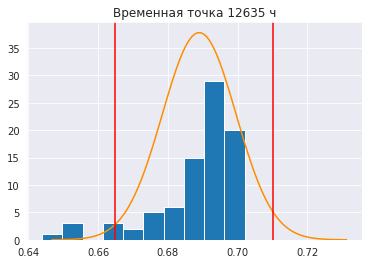

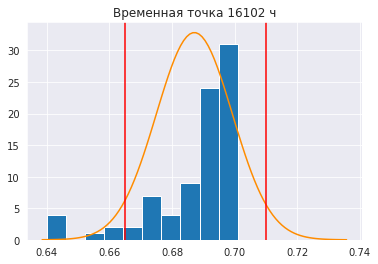

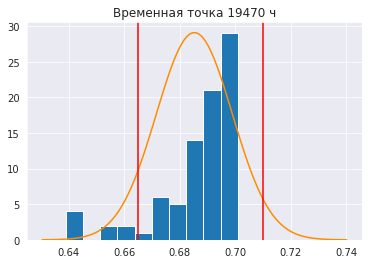

In [8]:
for i, j, k, l in zip(time_labels, columns, mean_test, std_test):
    x = np.linspace(k - 4 * l, k + 4 * l, 100)
    plt.title(f'Временная точка {i} ч')
    plt.hist(test[j])
    plt.plot(x, sps.norm(loc=k, scale=l).pdf(x), color='darkorange')
    plt.axvline(bottom_limit, 0, 1, color='red')
    plt.axvline(top_limit, 0, 1, color='red')
    plt.show()

Получение вероятности вида $P$ в соответствии с выражением (1) методики по смоделированным данным.

In [9]:
test_working_predict = []
for i, j in zip(mean_test, std_test):
    test_working_predict.append(sps.norm(loc=i, scale=j).cdf(top_limit) - sps.norm(loc=i, scale=j).cdf(bottom_limit))

Получение вероятности вида $P$ в соответствии с выражением (1) методики по экспериментальным данным

In [10]:
test_working_experiment = []
for i in columns:
    working = 0
    for j in test[i]:
        if j > bottom_limit and j < top_limit:
            working += 1
    test_working_experiment.append(working / test.shape[0])

In [11]:
test_error = 0
for p, e in zip(test_working_predict, test_working_experiment):
    test_error += pow((p - e) / e, 2)
test_error = np.sqrt(test_error / len(test_working_predict))

In [12]:
print(f"Процент рабочих устройств:\n{'Время'.ljust(8)}{'Прогноз'.ljust(21)}Реальное значение")
for t, p, e in zip(time_labels, test_working_predict, test_working_experiment):
    print(f"{str(t).ljust(8)}{str(p).ljust(21)}{e}")
print(f"Ошибка: {test_error}")

Процент рабочих устройств:
Время   Прогноз              Реальное значение
0       0.9987764996716633   1.0
995     0.9979015568778968   1.0
4844    0.9923346431603927   1.0
8757    0.9832814451643723   0.9523809523809523
12635   0.9653197270470438   0.9285714285714286
16102   0.9357602492389503   0.9166666666666666
19470   0.8949436177969567   0.9047619047619048
Ошибка: 0.021498110328271446


 # Распределение Вейбулла

In [ ]:
weibull = sps.weibull_max

In [ ]:
linear_regression = []
loc = []
scale = []
for i in train_splits:
    train_mean0 = np.array(i[columns[0]]).mean()
    train_std0 = np.array(i[columns[0]]).std()
    for t, c in zip(time_labels, columns):
        linear_regression.append([t, train_mean0, train_std0])
        _shape, _loc, _scale = weibull.fit(i[c], fc=shape)
        loc.append(_loc)
        scale.append(_scale)
linear_regression_x = np.array(linear_regression)

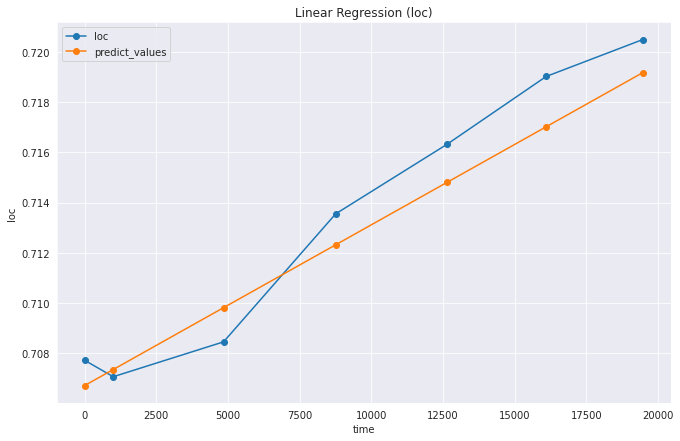

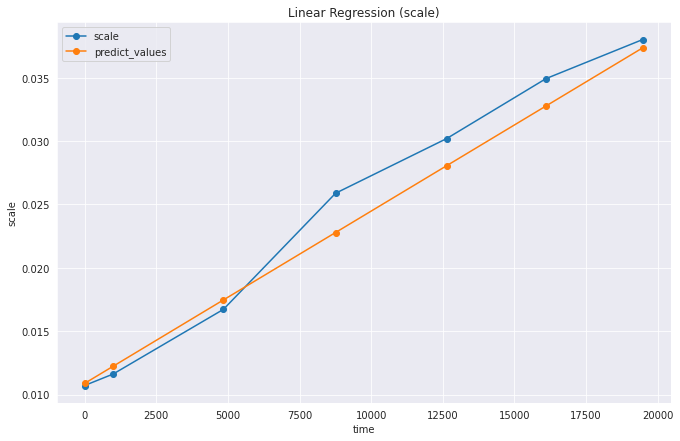

In [ ]:
model_loc = LinearRegression()
model_loc.fit(linear_regression, loc)

model_scale = LinearRegression()
model_scale.fit(linear_regression, scale)

train_mean0 = np.array(train[columns[0]]).mean()
train_std0 = np.array(train[columns[0]]).std()
linear_regression_train = np.array([[i, train_mean0, train_std0] for i in time_labels])

plt.figure(figsize=(11, 7))
plt.title('Linear Regression (loc)')
plt.xlabel('time')
plt.ylabel('loc')
plt.plot(time_labels, [weibull.fit(train[i], fc=shape)[1] for i in columns], label="loc", marker="o")
plt.plot(time_labels, model_loc.predict(linear_regression_train), label="predict_values", marker="o")
plt.legend()
plt.show()

plt.figure(figsize=(11, 7))
plt.title('Linear Regression (scale)')
plt.xlabel('time')
plt.ylabel('scale')
plt.plot(time_labels, [weibull.fit(train[i], fc=shape)[2] for i in columns], label="scale", marker="o")
plt.plot(time_labels, model_scale.predict(linear_regression_train), label="predict_values", marker="o")
plt.legend()
plt.show()

In [ ]:
test_mean0 = np.array(test[columns[0]]).mean()
test_std0 = np.array(test[columns[0]]).std()
linear_regression_x_test = np.array([[i, test_mean0, test_std0] for i in time_labels])
loc_test = model_loc.predict(linear_regression_x_test)
scale_test = model_scale.predict(linear_regression_x_test)

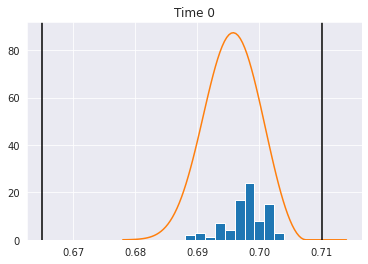

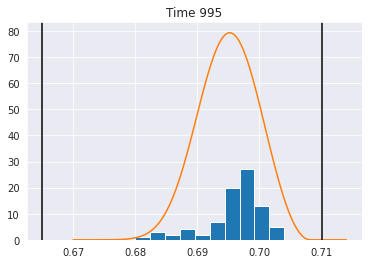

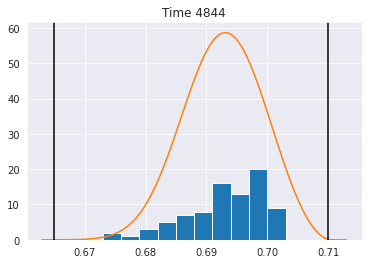

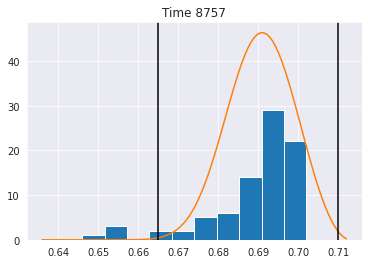

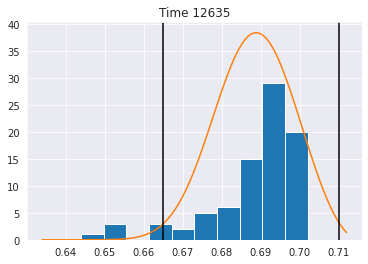

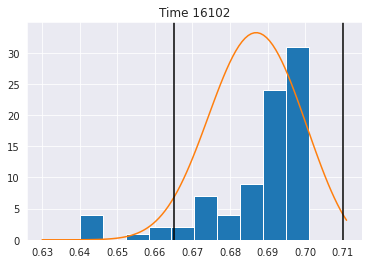

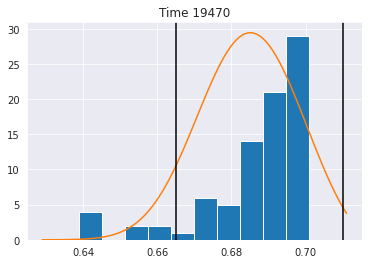

In [ ]:
for i, j, k, l in zip(time_labels, columns, loc_test, scale_test):
    x = np.linspace(test[j].min() - 0.01, test[j].max() + 0.01, 100)
    plt.title(f'Time {i}')
    plt.hist(test[j])
    plt.plot(x, weibull(shape, k, l).pdf(x))
    plt.axvline(bottom_limit, 0, 1, color='k')
    plt.axvline(top_limit, 0, 1, color='k')
    plt.show()

In [ ]:
test_working_predict = []
for loc, scale in zip(loc_test, scale_test):
    top = weibull.cdf(x=top_limit, c=shape, loc=loc, scale=scale)
    bottom = weibull.cdf(x=bottom_limit, c=shape, loc=loc, scale=scale)
    test_working_predict.append(top - bottom)

In [ ]:
test_working_experiment = []
for i in columns:
    working = 0
    for j in test[i]:
        if bottom_limit < j < top_limit:
            working += 1
    test_working_experiment.append(working / test.shape[0])

In [ ]:
test_error = 0
for p, e in zip(test_working_predict, test_working_experiment):
    test_error += pow((p - e) / e, 2)
test_error = np.sqrt(test_error / len(test_working_predict))

In [ ]:
print(f"Процент рабочих устройств:\n{'Время'.ljust(8)}{'Прогноз'.ljust(21)}Реальное значение")
for t, p, e in zip(time_labels, test_working_predict, test_working_experiment):
    print(f"{str(t).ljust(8)}{str(p).ljust(21)}{e}")
print(f"Ошибка: {test_error}")

Процент рабочих устройств:
Время   Прогноз              Реальное значение
0       0.9999999999999806   1.0
995     0.9999999999823508   1.0
4844    0.999963494617035    1.0
8757    0.9970608662845897   0.9523809523809523
12635   0.9828680371668723   0.9285714285714286
16102   0.9536510339907109   0.9166666666666666
19470   0.9109678165849042   0.9047619047619048
Ошибка: 0.032282092604177234
